# Import Libaries

In [9]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import glob

import os, json, math, time
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

# Create Custom Functions

In [5]:
def write_json(new_data, filename):
    """ Appends a list of records (new_data) to a json file (filename).
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""
    
    with open(filename, 'r+') as file:
        # first we load existing data into a dict.
        file_data = json.load(file)
        ## chose extend or append
        if(type(new_data) == list) & (type(file_data)== list):
            file_data.extend(new_data)
        else:
                file_data.append(new_data)
                # set file's current position at offset.
                file.seek(0)
                #conver back to json.
                json.dump(file_data, file)

In [6]:
def get_movie_with_rating(movie_id):
    """Copied from Coding Dojo Learning Platform"""
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    # save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
            info['certification'] = c['certification']
    
    return info

# Load Basics Data

In [8]:
basics = pd.read_csv("Data/title_basics.csv.gz")
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0043139,movie,Life of a Beijing Policeman,Wo zhe yi bei zi,0,2013.0,NaN,120,"Drama,History"
2,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
...,...,...,...,...,...,...,...,...,...
81838,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
81839,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
81840,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
81841,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


# API Extraction (TMDB)

### Establish API Connection


In [9]:
import json
with open('/Users/tjbingamon/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()

dict_keys(['api-key', 'api-read-token'])

In [10]:
tmdb.API_KEY =  login['api-key']

# Assign folder to save results

In [11]:
FOLDER = 'Data/'
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['title_akas (1).csv.gz',
 'tmdb_api_results_2000.json',
 'final_tmdb_data_2000.csv.gz',
 'tmdb_api_results_2001.json',
 'title_basics.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'tmbd_results_combined.csv.gz',
 'title_ratings.csv.gz']

# Object for Year Range to Retrieve

In [12]:
YEARS_TO_GET = range(2010, 2023)
errors = []

In [13]:
"""Adapted from Coding Dojo Learning Platform"""
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'

    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)

    #Saving new year as the current df
    #Filter for basics df for only specific year
    df = basics[basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    
    ###Stop gap measure to insure previously retrieved data isn't retrieved again
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)

    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

#############################################################################
    #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve the data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)

        except Exception as e:
            errors.append([movie_id, e])
#############################################################################        
    
    #save file as .csv.gz  
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", 
                         compression="gzip", index=False)

# print number of errors
print(f"- Total errors: {len(errors)}")

YEARS:   0%|          | 0/13 [00:00<?, ?it/s]

Movies from 2010:   0%|          | 0/3861 [00:00<?, ?it/s]

Movies from 2011:   0%|          | 0/4229 [00:00<?, ?it/s]

Movies from 2012:   0%|          | 0/4522 [00:00<?, ?it/s]

Movies from 2013:   0%|          | 0/4711 [00:00<?, ?it/s]

Movies from 2014:   0%|          | 0/4914 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/5055 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/5255 [00:00<?, ?it/s]

Movies from 2017:   0%|          | 0/5641 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/5779 [00:00<?, ?it/s]

Movies from 2019:   0%|          | 0/5876 [00:00<?, ?it/s]

Movies from 2020:   0%|          | 0/5004 [00:00<?, ?it/s]

Movies from 2021:   0%|          | 0/5153 [00:00<?, ?it/s]

Movies from 2022: 0it [00:00, ?it/s]

- Total errors: 13710


# Use Glob to Combine Files

In [12]:
q = "Data/final_tmdb_data_*.csv.gz"
chunked_files = glob.glob(q)
# Showing the first 5
files_to_get = chunked_files
files_to_get

['Data/final_tmdb_data_2018.csv.gz',
 'Data/final_tmdb_data_2014.csv.gz',
 'Data/final_tmdb_data_2022.csv.gz',
 'Data/final_tmdb_data_2016.csv.gz',
 'Data/final_tmdb_data_2020.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2012.csv.gz',
 'Data/final_tmdb_data_2010.csv.gz',
 'Data/final_tmdb_data_2019.csv.gz',
 'Data/final_tmdb_data_2015.csv.gz',
 'Data/final_tmdb_data_2021.csv.gz',
 'Data/final_tmdb_data_2017.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2013.csv.gz',
 'Data/final_tmdb_data_2011.csv.gz']

In [13]:
df = pd.concat([pd.read_csv(f,lineterminator='\n') for f in files_to_get])
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069049,0.0,/wXUcSJG6dqNKgIRgqYqX98UA1wz.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,299782.0,en,The Other Side of the Wind,...,0.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,40 years in the making.,The Other Side of the Wind,0.0,6.721,181.0,R
2,tt0192528,0.0,/gkBxjhtVEqgxOiRwRfWw1j7ez6K.jpg,NaN,5000000.0,"[{'id': 18, 'name': 'Drama'}]",NaN,567662.0,en,Reverse Heaven,...,0.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Heaven's in trouble and there's one man who ca...,Heaven & Hell,0.0,6.000,7.0,NaN
3,tt0276568,0.0,NaN,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://networkonair.com/all-products/2806-man...,1057586.0,en,To Chase A Million,...,0.0,98.0,[],Released,A key to a fortune... a key to death!,To Chase A Million,0.0,0.000,0.0,NaN
4,tt0360556,0.0,/7oy4miyq4WYYy0xtX6lbNVPrEsr.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",https://www.hbo.com/movies/fahrenheit-451,401905.0,en,Fahrenheit 451,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Knowledge is a dangerous thing,Fahrenheit 451,0.0,5.426,767.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,...,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.000,1.0,NaN
3018,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,...,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,6.000,1.0,NaN
3019,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,...,0.0,73.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Wrong Ferarri,0.0,5.000,2.0,NaN
3020,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,...,0.0,0.0,[],Released,NaN,North point,0.0,0.000,0.0,NaN


# Clean Groups
change/combine:
- '10' = 'G'
- 'PG-13 ' (has extra space) = 'PG-13'
- 'Unrated' = 'NR'

In [15]:
df['certification'].value_counts()

R          4122
NR         2917
PG-13      2209
PG         1011
G           344
NC-17       126
Unrated       5
PG-13         1
10            1
Name: certification, dtype: int64

In [16]:
df['certification'] = df['certification'].str.replace('10', 'PG')
df['certification'] = df['certification'].str.replace('PG-13 ', 'PG-13')
df['certification'] = df['certification'].str.replace('Unrated', 'NR')
df['certification'].value_counts()

R        4122
NR       2922
PG-13    2210
PG       1012
G         344
NC-17     126
Name: certification, dtype: int64

# Hypothesis Testing

# Q1: Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

## 1: State Null/Alternative Hypothesis

- Null Hypothesis: movie rating does not affect how much revenue a movie generates

- Alternative Hypothesis: movie rating does affect how much revenue a movie generates

- Alpha: 0.05

##  2: Type of Test
- ANOVA
- Comparing numeric data: revenue
- More than 2 groups: G, PG, PG-13, R

In [19]:
df2 = df.copy()

### Drop 'NR' and 'NC-17'

- Do not need these two ratings.

In [20]:
df2 = df2[(df2['certification'] != 'NR') & (df2['certification'] != 'NC-17')]
df2['certification'].value_counts()

R        4122
PG-13    2210
PG       1012
G         344
Name: certification, dtype: int64

## Separate Groups

In [22]:
groups = {}
## Loop through all unique categories
for i in df2['certification'].unique():
    ## Get series for group and rename
    data = df2.loc[df2['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['R', nan, 'PG-13', 'PG', 'G'])

In [23]:
# Citation: https://stackoverflow.com/questions/24068306/
# is-there-a-way-to-remove-nan-from-a-dictionary-filled-with-data
# Raghul Raj
groups = {k: groups[k] for k in groups if not pd.isna(k)}

In [24]:
groups.keys()

dict_keys(['R', 'PG-13', 'PG', 'G'])

## 3: Assumptions

- Equal Variance
- No significant outliers
- Normality

In [25]:
# Significant Outliers
for i in groups:
    print(f'{i} - Number of rows: {len(groups[i])}')
    z_score = stats.zscore(groups[i])
    outliers = abs(z_score)>3
    print(f'{i} - Number of outliers: {np.sum(outliers)}')
    
    groups[i] = groups[i][~outliers]
    print(f'{i} - Number of rows: {len(groups[i])}')
    print('')

R - Number of rows: 4122
R - Number of outliers: 87
R - Number of rows: 4035

PG-13 - Number of rows: 2210
PG-13 - Number of outliers: 63
PG-13 - Number of rows: 2147

PG - Number of rows: 1012
PG - Number of outliers: 26
PG - Number of rows: 986

G - Number of rows: 344
G - Number of outliers: 8
G - Number of rows: 336



### Normality

- if we have >15, we can continue

In [26]:
# Normality
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
R,4035.0,0.000000e+00,3229.170622
PG-13,2147.0,0.000000e+00,1469.033721
PG,986.0,3.457573e-137,628.427182
G,336.0,1.919820e-85,390.135003


### Equal Variance

Failed assumption of Equal Variance

In [27]:
stats.levene(*groups.values())

LeveneResult(statistic=156.49844233806323, pvalue=2.1862394812949493e-98)

## 4: Perform Test & Interpret Result

- Our assumption of Equal Variance was not met
- Proceed with Kruskal-Wallis Test
- p-value < 0.05 (alpha), reject Null Hypothesis and support Alternative Hypothesis: "Movie rating does not affect revenue."

In [28]:
results = stats.kruskal( *groups.values())
results

KruskalResult(statistic=232.51849659121794, pvalue=3.947068757779618e-50)

In [30]:
# is result significant?
print(f"p-value={results.pvalue:.10f}")
print(f"Significant: {results.pvalue <.05}")

p-value=0.0000000000
Significant: True


### Visualization

In [40]:
groups_df = pd.DataFrame(index=[0], data={'revenue': 0, 'certification':0})
groups_df

,revenue,certification
0,0,0


In [42]:
for i in groups:
    groups_temp = pd.DataFrame(groups[i])
    groups_temp['certification'] = i
    groups_df = pd.concat([groups_df, groups_temp])

groups_df.index.name='imdb_id'
groups_df

,revenue,certification
imdb_id,,
0,0.0,0
1,0.0,R
7,18850674.0,R
34,6348889.0,R
87,34017028.0,R
...,...,...
2662,0.0,G
2819,0.0,G
2827,0.0,G


In [43]:
groups_df.drop(index=0, inplace=True)
groups_df

,revenue,certification
imdb_id,,
1,0.0,R
7,18850674.0,R
34,6348889.0,R
87,34017028.0,R
113,7649973.0,R
...,...,...
2662,0.0,G
2819,0.0,G
2827,0.0,G


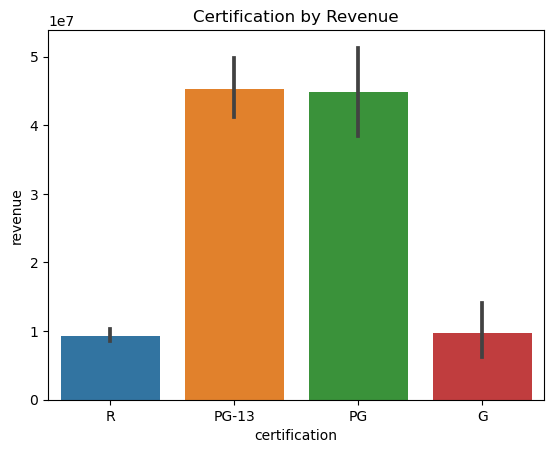

In [44]:
fig, ax = plt.subplots()

ax = sns.barplot(data=groups_df, x=groups_df['certification'], y=groups_df['revenue'])
ax.set_title('Certification by Revenue');

## 5: Pairwise Tukey Comparison Test

### Shows 4 significant results

- 'reject' column

Reject null hypothesis for groups:

- 'G' and 'PG'
- 'G' and 'PG-13'
- 'PG' and 'R'
- 'PG-13' and 'R'
- There is a significant difference in the results of ratings 'PG' and 'PG-13' compared to the other two ratings



'PG' and 'PG-13' return the most revenue

In [45]:
values = groups_df['revenue']
labels = groups_df['certification']

In [46]:
tukey_q1 = pairwise_tukeyhsd(values, labels)
tukey_q1.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,35074760.2789,0.0,23628240.9829,46521279.5749,True
G,PG-13,35561686.2491,0.0,24930823.4755,46192549.0226,True
G,R,-387404.2741,0.9997,-10676206.2432,9901397.6949,False
PG,PG-13,486925.9702,0.9979,-6484017.0211,7457868.9614,False
PG,R,-35462164.553,0.0,-41899419.3123,-29024909.7938,True
PG-13,R,-35949090.5232,0.0,-40789616.1301,-31108564.9162,True


# Q2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

## 1: State Null/Alternative Hypothesis

- Null Hypothesis: there is no difference in earned revenue between movies that are over 2.5 hours long and movies that are 1.5 hours long (or less)

- Alternative Hypothesis: there is a difference in earned revenue between movies that are over 2.5 hours long and movies that are 1.5 hours long (or less)

- Alpha: 0.05

## 2: Type of Test

- Independent T-test
  - Comparing numeric data: revenue
  - Comparing 2 samples: movies that are over 2.5 hours long and movies that are 1.5 hours (or less) long

## Create 2 Groups of Data

In [47]:
# long_movie
longer_movie = df[df['runtime'] >= 150]
longer_movie

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
23,tt10182822,0.0,/zVHRrSRbvvlWLrdQCsRC604XSRG.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,541660.0,it,Loro,...,0.0,157.0,"[{'english_name': 'Italian', 'iso_639_1': 'it'...",Released,Everything is not enough.,Loro,0.0,6.68,250.0,NaN
34,tt1034415,0.0,/AmO8I38bkHwKhgxPNrd6djBQyPU.jpg,NaN,20000000.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 27, 'na...",https://www.amazon.com/dp/B07H9KG2PB,361292.0,en,Suspiria,...,6348889.0,152.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Give your soul to the dance.,Suspiria,0.0,6.94,2242.0,R
41,tt10462646,0.0,/mzdSndlQJc2m7qanhZpEbPMUbwA.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 14, 'nam...",NaN,617913.0,mn,Говийн домог,...,0.0,158.0,"[{'english_name': 'Mongolian', 'iso_639_1': 'm...",Released,NaN,The Legend of Gobi,0.0,0.00,0.0,NaN
137,tt13442198,1.0,NaN,NaN,0.0,[],NaN,637918.0,en,Vegas Nights,...,0.0,185.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,If a year spent driving a town car in Las Vega...,Vegas Nights,0.0,7.00,1.0,NaN
218,tt2226440,0.0,/7MZ4UcW6pM2rNDLbULEwS82N2Vf.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 37, 'name...",http://www.deadmentheseries.com,500321.0,en,Dead Men,...,0.0,177.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"Divided by Death, Bound by Vengeance",Dead Men,0.0,5.90,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,tt2238976,0.0,/5E8HwOvI2EO09VBZIU7f8UCGNFg.jpg,NaN,0.0,[],NaN,57608.0,en,Jewel: The Essential Live Songbook,...,0.0,266.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Jewel: The Essential Live Songbook,0.0,8.50,2.0,NaN
2941,tt2905606,0.0,NaN,NaN,1.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 53, 'nam...",NaN,256024.0,en,Vishnuvardhana,...,0.0,169.0,"[{'english_name': 'Kannada', 'iso_639_1': 'kn'...",Released,NaN,Vishnuvardhana,0.0,5.90,8.0,NaN
2976,tt3703964,0.0,/9rOzcW5OBxd1lcFGT8xnO0TwaGJ.jpg,NaN,0.0,"[{'id': 10402, 'name': 'Music'}]",NaN,374830.0,en,Deep Purple & Orchestra - Live At Montreux 2011,...,0.0,167.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Deep Purple & Orchestra - Live At Montreux 2011,1.0,4.00,3.0,NaN
2992,tt5521056,0.0,/lWzC7ZUIUmF08MdCtU6ZKJvKroX.jpg,"{'id': 1004047, 'name': 'Boys on Film Collecti...",0.0,[],NaN,420853.0,en,Boys On Film 7: Bad Romance,...,0.0,164.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Boys On Film 7: Bad Romance,1.0,6.40,5.0,NaN


In [48]:
# short movie
short_movie = df[df['runtime'] <= 90]
short_movie

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
9,tt10004396,0.0,/jCNOC0xYXvOlVcnnK49f6b6wvzT.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",http://www.shorelineentertainment.com/portfoli...,748825.0,fa,Vaghti parvaneh shodam,...,0.0,88.0,"[{'english_name': 'Persian', 'iso_639_1': 'fa'...",Released,"Based on true events, a meek woman in an unhap...",When I Became a Butterfly,0.0,6.0,1.0,NaN
11,tt10010814,0.0,/uMKRXadvYWaTg75ROAmiy47tX8u.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,921419.0,en,Turtle,...,0.0,0.0,[],Released,NaN,Turtle,0.0,0.0,0.0,NaN
12,tt10027474,0.0,/WC6DoQpowPv1jLRsUk40Q9upsp.jpg,NaN,0.0,[],NaN,604699.0,ja,温泉しかばね芸者,...,0.0,48.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Night of the Dead Geisha,0.0,0.0,0.0,NaN
13,tt10028708,0.0,/jzbUaEPaPq8pHpJMAx3lhrCROCU.jpg,NaN,65000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,824392.0,en,Stay,...,0.0,67.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Stay,0.0,0.0,0.0,NaN
14,tt10075070,0.0,/sbjQrQB5poM12QujYiwxWqVAv15.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,544478.0,pt,Os Jovens Baumann,...,0.0,70.0,"[{'english_name': 'Portuguese', 'iso_639_1': '...",Released,NaN,Os Jovens Baumann,0.0,6.9,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,tt8898566,0.0,/lLtszfYjHRc2GDQyPTW6VCQ0Qjh.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,355040.0,ko,마지막 밀애,...,0.0,55.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,The Last Liaison,0.0,0.0,0.0,NaN
3017,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,...,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
3019,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,...,0.0,73.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Wrong Ferarri,0.0,5.0,2.0,NaN
3020,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,...,0.0,0.0,[],Released,NaN,North point,0.0,0.0,0.0,NaN


In [49]:
long_revenue = longer_movie['revenue']
short_revenue = short_movie['revenue']

## 3: Assumptions

- No significant outliers
- Normality
- Equal Variance

### Outliers

In [50]:
# longer revenue
zscores_long = stats.zscore(long_revenue)
outliers_long = abs(zscores_long)>3
print(f'Len: {len(long_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_long)}')

long_revenue = long_revenue[~outliers_long]
print(f'Len: {len(long_revenue)}')

Len: 970
Number of Ouliers: 15
Len: 955


In [51]:
# shorter revenue
zscores_short = stats.zscore(short_revenue)
outliers_short = abs(zscores_short)>3
print(f'Len: {len(short_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_short)}')

short_revenue = short_revenue[~outliers_short]
print(f'Len: {len(short_revenue)}')

Len: 21594
Number of Ouliers: 121
Len: 21473


### Normality

- both groups have sample count > 15, we can skip this step

### Equal Variance

- Equal Variance assumption is not met
- Will add equal_var=False argument to test

In [52]:
stats.levene(long_revenue, short_revenue)

LeveneResult(statistic=978.7349829611733, pvalue=2.470976050219864e-210)

## 4: Perform Test & Interpret Result

- p-value < 0.05 (alpha), reject Null Hypothesis and support Alternative Hypothesis

- Runtime length does affect revenue

In [53]:
result = stats.ttest_ind(long_revenue, short_revenue, equal_var=False)
result

Ttest_indResult(statistic=6.692236976823842, pvalue=3.742921811374346e-11)

In [54]:
## is our result significant
print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue <.05}")

p-value=0.0000000000
Significant: True


In [57]:
long_rev = pd.DataFrame(long_revenue)
long_rev['runtime'] = 'long'
long_rev

,revenue,runtime
23,0.0,long
34,6348889.0,long
41,0.0,long
137,0.0,long
218,0.0,long
...,...,...
2834,0.0,long
2941,0.0,long
2976,0.0,long
2992,0.0,long


In [58]:
short_rev = pd.DataFrame(short_revenue)
short_rev['runtime'] = 'short'
short_rev

,revenue,runtime
9,0.0,short
11,0.0,short
12,0.0,short
13,0.0,short
14,0.0,short
...,...,...
3016,0.0,short
3017,0.0,short
3019,0.0,short
3020,0.0,short


In [59]:
plot_2 = pd.concat([long_rev, short_rev])
plot_2

,revenue,runtime
23,0.0,long
34,6348889.0,long
41,0.0,long
137,0.0,long
218,0.0,long
...,...,...
3016,0.0,short
3017,0.0,short
3019,0.0,short
3020,0.0,short


In [61]:
print(f'Long Movie Revenue: {long_revenue.mean():,.2f}')
print(f'Short Movie Revenue: {short_revenue.mean():,.2f}')

Long Movie Revenue: 11,777,295.58
Short Movie Revenue: 178,676.43


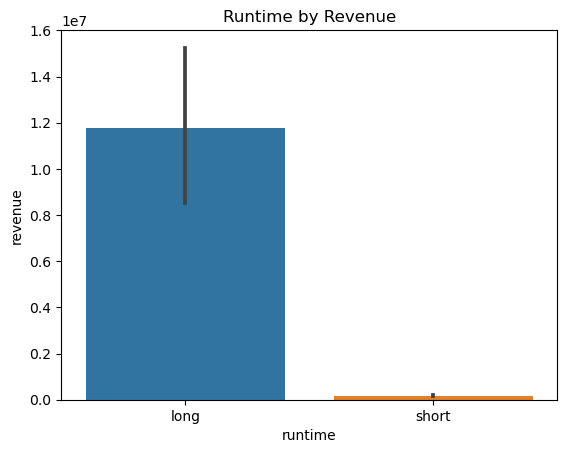

In [63]:
fig, ax = plt.subplots()

ax = sns.barplot(data=plot_2, x='runtime', y='revenue')
ax.set_title('Runtime by Revenue');

# Q3: Do some movie genres earn more revenue than others?